In [1]:
# gridding TNO dataset
# each NetCDF file contains yearly emission of co2 (ff&bf), co (ff&bf), nox, ch4 and nmvoc
# units: kg/year
# each variable is stored in 1-d array of length 3.7 million
# use longitude_index and latitude_index to grid
# sum up if two data points share a grid box

# fastest code is as follows, 
# put 1-d arrays into pandas dataframe and use built-in functions:
# Dataframe.sort_values(), Dataframe.groupby(), Dataframe.to_netcdf(), 
# takes <10s each file
# for loop takes >30m each file, NOT RECOMMENDED!

In [2]:
import pandas as pd # pandas package
import numpy as np
import xarray as xr # the major tool to work with NetCDF data!
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from gamap_colormap import WhGrYlRd

In [9]:
def grip_tno(year):  
    fdir = '/geos/d21/msadiq/TNO-GHGco/original/TNO_GHGco_6x6km_v1_1_recent_years/'
    #fdir = '/geos/d21/msadiq/TNO-GHGco/original/TNO_GHGco_6x6km_v1_1/NC/'
    fname = 'TNO_GHGco_v1_1_year'+str(year)+'.nc' # unit: kg/yr
    ds = xr.open_dataset(fdir + fname)
    varnames = ['co2_ff', 'co2_bf', 'co_ff', 'co_bf', 'nox', 'ch4', 'nmvoc']
    # combine lat, lon, co2 into a dataframe  
    lon = ds['longitude_index']
    lat = ds['latitude_index']
    df = pd.DataFrame({'lon': lon, 'lat': lat}) # length 3.7 million
    for i, varname in enumerate(varnames):
        df.insert(i+2, varname, ds[varname])
    # Sort the dataframe by lon and lat indices
    df_sorted = df.sort_values(by=['lat', 'lon'])
    df_sorted.set_index(['lat', 'lon'])
    # group them by same lat & lon, sum up
    df_grouped = df_sorted.groupby(['lat', 'lon']).sum() # reduce to 275k
    target = df_grouped.to_xarray()
    target['lat'].values = ds.latitude.values
    target['lon'].values = ds.longitude.values
    for ivar in varnames: target[ivar].attrs = ds[ivar].attrs # copy attributes
    target.attrs['comment'] = 'gridded from original TNO dataset, by m.sadiq 2020'
    target.to_netcdf('/geos/d21/msadiq/TNO-GHGco/gridded/TNO_'+str(year)+'_0.05x0.1.nc')
    # plot of ffCO2
    fig = plt.figure(figsize=[6, 6])
    proj=ccrs.PlateCarree()
    ax = plt.subplot(111, projection=proj)
    ax.coastlines()
    target['co2_ff'].plot(ax=ax, transform=ccrs.PlateCarree(), vmax=5e7, cmap=WhGrYlRd, cbar_kwargs={'shrink': 0.5, 'label': 'kgCO2/yr'})
    ax.set_xlim(-11,36)
    ax.set_ylim(36,62)
    ax.set_title(str(year) + ' TNO ffCO2');


CPU times: user 4.33 s, sys: 1.84 s, total: 6.16 s
Wall time: 9.59 s


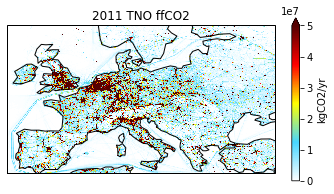

In [4]:
%%time
grip_tno(2011)

CPU times: user 11.8 s, sys: 4.16 s, total: 15.9 s
Wall time: 25 s


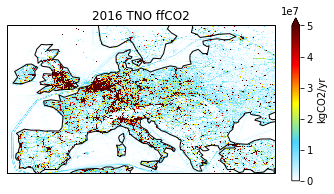

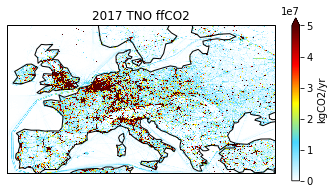

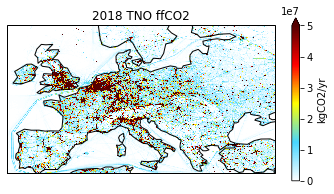

In [10]:
%%time
for iyear in range(2016,2019):
    grip_tno(iyear)